In [193]:
import pandas as pd
import numpy as np
import xgboost
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# Исследование данных

## Загрузка данных

In [104]:
# load the data
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')

# Check random row
random_number_train = np.random.randint(data_train.shape[0])
random_number_test = np.random.randint(data_test.shape[0])
#print(data_train.iloc[random_number_train])
#print(data_test.iloc[random_number_test])

# Select target
y = data_train.Churn

# Select features
X_train = data_train.drop('Churn', axis=1)
X_test = data_test

#Check missing values
#X_train.info()
#X_test.info()

cols_with_missing_X_train = [col for col in X_train
                     if X_train[col].isnull().any() or (X_train[col] == ' ').any()]
cols_with_missing_X_test = [col for col in X_test
                     if X_test[col].isnull().any() or (X_test[col] == ' ').any()]
#print('Cols with missing values in X_train:', cols_with_missing_X_train)
#print('Cols with missing values in X_test:', cols_with_missing_X_test)

# Imputation
def to_float_TotalSpent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Get DataFrame and converts the TotalSpent column to float 
    empty values = np.nan
    """
    for i, val in enumerate(data.TotalSpent):
        if val == ' ':
            data.TotalSpent.iloc[i] = np.nan
    data = data.astype({'TotalSpent': 'float64'})
    return data

X_train = to_float_TotalSpent(X_train)
X_test = to_float_TotalSpent(X_test)

#print(X_train[X_train['TotalSpent'].isna()])
print(X_train.isna().sum())

nan_row = X_train[X_train['TotalSpent'].isna()].index
X_train = X_train.drop(nan_row, axis=0)

y = y.drop(nan_row, axis=0)

#TotalSpent_X_train = np.array(X_train.TotalSpent).reshape(-1, 1)
#TotalSpent_X_test = np.array(X_test.TotalSpent).reshape(-1, 1)

#my_imputer = SimpleImputer()
#imputed_TotalSpent_X_train = pd.DataFrame(my_imputer.fit_transform(TotalSpent_X_train))
#imputed_TotalSpent_X_test = pd.DataFrame(my_imputer.transform(TotalSpent_X_test))

# Imputation removed column names: put the back and add in main DataFrame
#imputed_TotalSpent_X_train.columns = ['TotalSpent']
#imputed_TotalSpent_X_test.columns = ['TotalSpent']
#X_train.TotalSpent = imputed_TotalSpent_X_train
#X_test.TotalSpent = imputed_TotalSpent_X_test

# Find numerical and categorical columns
numerical_columns = [col for col in X_train
                     if X_train[col].dtypes in ['int64', 'float64']]
numerical_columns.remove('IsSeniorCitizen')
categorical_columns = [col for col in X_train
                       if X_train[col].dtypes == 'object']
categorical_columns.append('IsSeniorCitizen')

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64


## Анализ данных

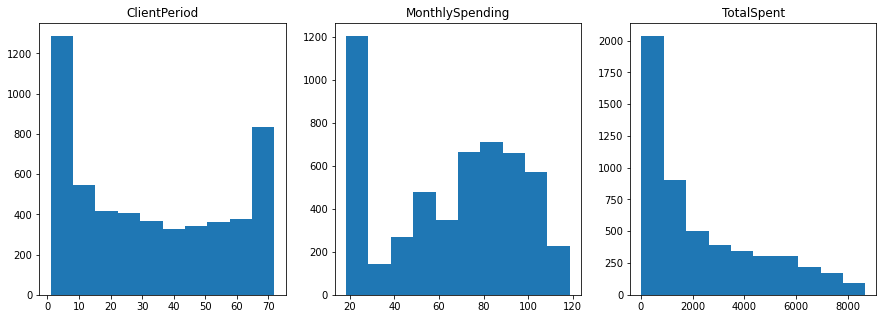

In [105]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    ax[i].set_title(column)
    ax[i].hist(X_train[column])
    
fig.show()

### Я попробовал проанализировать графики и думаю дела обстоят так:
##### -График ClientPeriod - думаю, эта калонка показывает сколько дней клиент пользуется услугами компании. Диапазон баров ~ 5. Получается у компании много новичков, которые держатся до 5 дней, после 5 дней примерно половина клиентов отключаются. Потеря клиентов идет до ~ 45-50 дней, после этого клиенты ,как правило, остаются.
##### -График  MonthlySpending - Ежемесячные расходы. диапазон баров ~ 10. Больше всего рассходов уходит на 20-30
##### -График TotalSpent - Всего потрачено. диапазон баров ~ 1000. Большая часть людей тратят ~ 1000 и чем больше эта цифра, тем меньше людей, что логично, ведь большие суммы тратят меньшее количество людей


## Bar chart for categorical columns

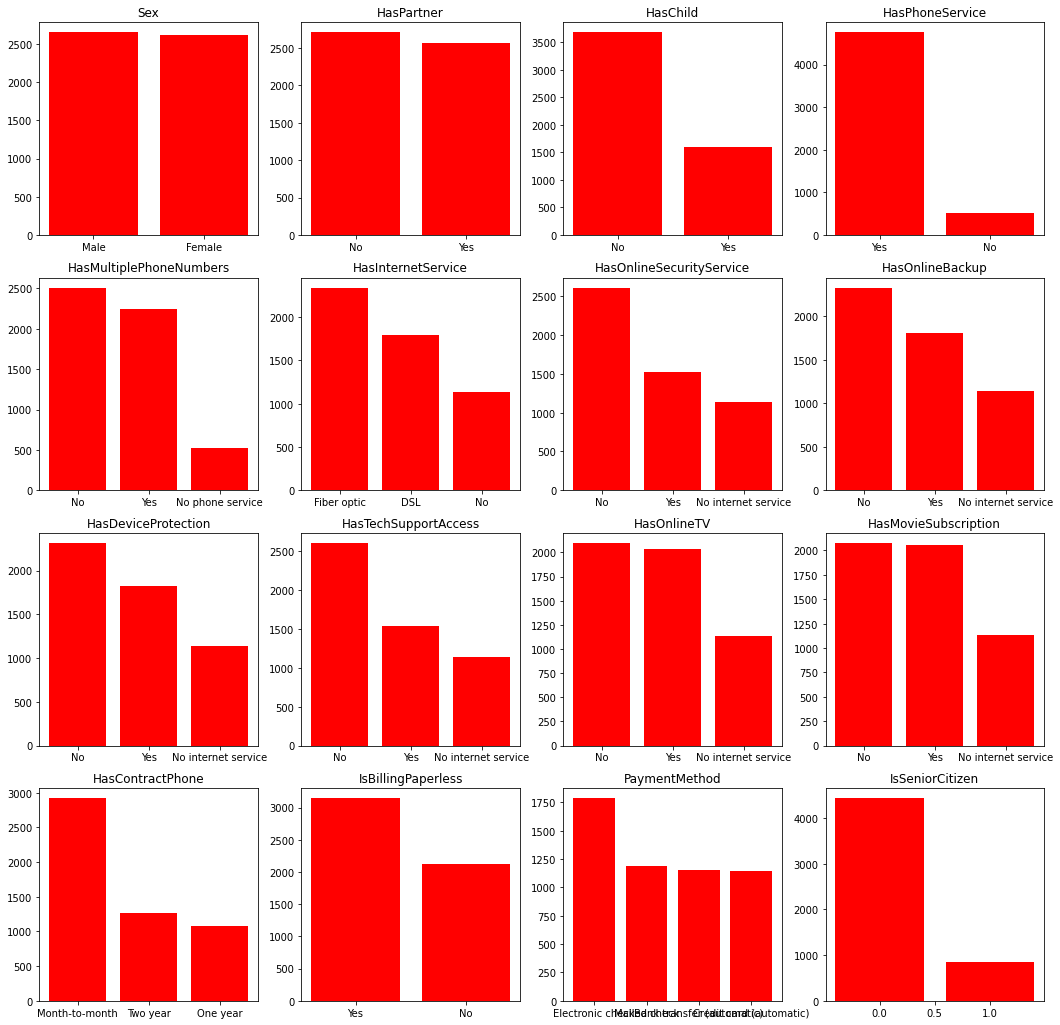

In [106]:
fig, ax = plt.subplots(4, 4, figsize=(18,18))

ax = ax.ravel()

for i, col in enumerate(categorical_columns):
    ax[i].set_title(col)
    x = X_train[col].value_counts()
    ax[i].bar(x.keys(), x, color='red')
fig.show()

#### Уникальных значений мало, поэтому перед обучением модели будем использовать hot-encoding для категориальных данных
#### По диаграммам можно сделать вывод, что в основном значения приблизительно равны,  большие различия имеют только:
#### HasChild, HasPhoneService, IsSeniorCitizen, остальные либо примерно равны, либо часть из них равна.

## Pie chart for categorical columns

In [107]:
#fig, ax = plt.subplots(4, 4, figsize=(18,18))

#ax = ax.ravel()

#for i, col in enumerate(categorical_columns):
    #ax[i].set_title(col)
    #x = X_train[col].value_counts()
    #ax[i].pie(x, labels = x.keys())
#fig.show()

### Распределение целевой переменной (проверка на сбалансированность классов)

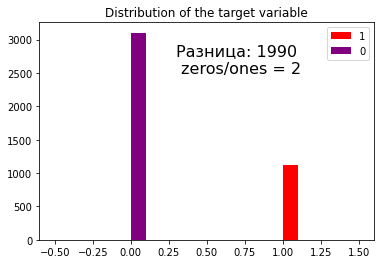

In [108]:
units = [one for one in y_train
         if one == 1]
zeros = [zero for zero in y_train
         if zero == 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.set_title('Distribution of the target variable')
ax.hist(units, color='red', label='1')
ax.hist(zeros, color='purple', label='0')
ax.legend()
ax.text(0.30, 2500, f'Разница: {len(zeros) - len(units)} \n zeros/ones = {len(zeros) // len(units)}', size=16)

fig.show()

#### Классов "0" в 2 раза больше, чем классов "1". Это не такая большая разница, поэтому делаем вывод, что классы сбалансированы.

## Применение линейных моделей

#### One-hot encoding

In [109]:
# Apply one-hot encoder for each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_columns]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[categorical_columns]))

# One-hot encoding removed index; put the back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns
num_X_train = X_train.drop(categorical_columns, axis=1)
num_X_test = X_test.drop(categorical_columns, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

#### Standard Scaler

In [110]:
standard = StandardScaler()
X = standard.fit_transform(OH_X_train)
X_for_pred = standard.transform(OH_X_test)


#### Обучение модели и расчет roc auc

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# Обучаем модель
model = LogisticRegressionCV(scoring='roc_auc', refit=True, n_jobs=4)
model.fit(X_train, y_train)
# получаем предсказания и сохраняем вероятности только для положительного исхода
y_pred = model.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, y_pred)
print(f'LogisitcRegressionCV: ROC AUC = {lr_auc}')
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, y_pred)
#print(f'False Positive Rate = {fpr} \n True Positive Rate = {tpr} \n Treshold = {treshold}')
roc_auc = auc(fpr, tpr)
#print(f'ROC AUC = {roc_auc}')
#print('Max auc_roc:', model.scores_[1].mean(axis=0).max())
model.get_params()

LogisitcRegressionCV: ROC AUC = 0.843798065581505


{'Cs': 10,
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': 4,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

#### Построение ROC кривой

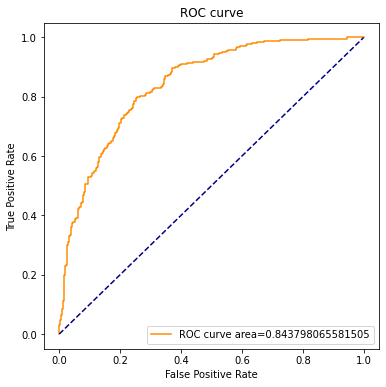

In [149]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve area={roc_auc}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [159]:
boosting_model = xgboost.XGBClassifier(n_estimators=1000, learning_rate=0.01, n_jobs=-1)
boosting_model.fit(X_train, y_train,
                   early_stopping_rounds=15,
                   eval_set=[(X_test, y_test)],
                   verbose=False)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

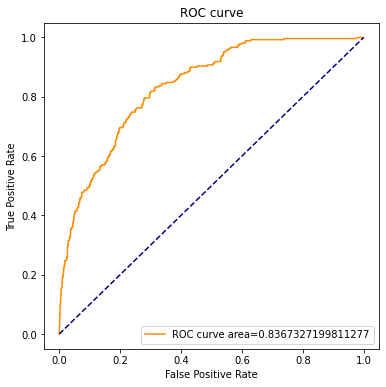

In [160]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

fpr, tpr, treshold = roc_curve(y_test, y_test_predicted)
#print(f'False Positive Rate = {fpr} \n True Positive Rate = {tpr} \n Treshold = {treshold}')
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve area={roc_auc}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [230]:
best_model = boosting_model
submission = pd.read_csv('data/submission.csv')

submission['Churn'] = best_model.predict_proba(X_for_pred)[:, 1]
submission.to_csv('data/my_submission.csv', index=False)


In [191]:
pd.read_csv('data/submission.csv')

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
1756,1756,0.5
1757,1757,0.5
1758,1758,0.5
1759,1759,0.5


In [228]:
data = pd.read_csv('data/my_submission.csv')
#print(data.head())
#data = data.drop(labels=1, axis=1)
data = data.drop(columns=['Unnamed: 0'], axis=1)
#data.to_csv('my_submission', encoding='utf-8', index=False)
data

,Id,Churn
0,0,0.049482
1,1,0.713052
2,2,0.643846
3,3,0.040597
4,4,0.018147
...,...,...
1756,1756,0.280795
1757,1757,0.025046
1758,1758,0.878289
1759,1759,0.551439
